In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import lineagevi
import scvelo as scv
import numpy as np

In [3]:
adata_path = '/Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas_2025.08.17_12.43.17/adata_with_velocity.h5ad'
adata = sc.read_h5ad(adata_path)

In [4]:
model_path = '/Users/lgolinelli/git/lineageVI/notebooks/data/outputs/pancreas_2025.08.17_12.43.17/vae_velocity_model.pt'

linvi = lineagevi.utils.load_model(
    adata,
    model_path=model_path,
    map_location='cpu',
    n_hidden=128,
    training=False
)

In [5]:
outs = linvi.get_model_outputs(adata)

computing velocity graph (using 1/10 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


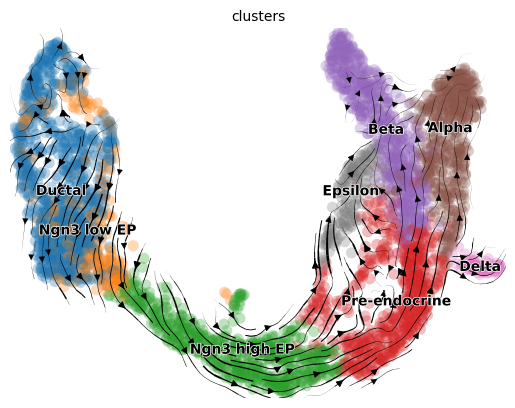

In [6]:
adata_gp = lineagevi.utils.build_gp_adata(adata, linvi, n_samples=100, return_negative_velo=True)
sc.pp.neighbors(adata_gp)
scv.tl.velocity_graph(adata_gp)
scv.pl.velocity_embedding_stream(adata_gp, color='clusters')

In [8]:
scv.tl.velocity_graph(adata_gp, vkey='velocity')
T = scv.tl.transition_matrix(adata_gp, vkey='velocity').toarray()

computing velocity graph (using 1/10 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity graph (using 1/10 cores)
    finished (0:00:21) --> added 
    'gp2gene_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'gp2gene_velocity_umap', embedded velocity vectors (adata.obsm)


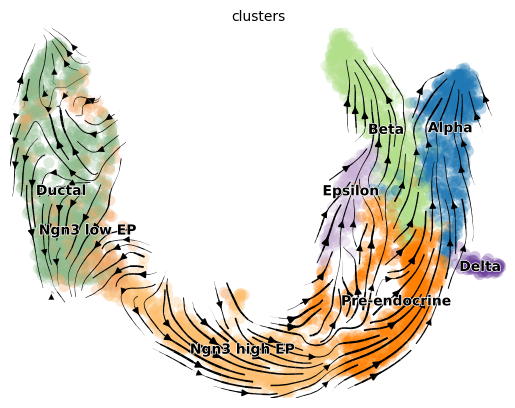

In [9]:
initial_state = adata.layers['Ms']
future_state = np.matmul(T,initial_state)
scale = 10

velo_mapped = (future_state - initial_state)*scale
adata.layers['gp2gene_velocity'] = velo_mapped
scv.tl.velocity_graph(adata, vkey='gp2gene_velocity', xkey='Ms')
scv.pl.velocity_embedding_stream(adata, vkey='gp2gene_velocity', color='clusters')

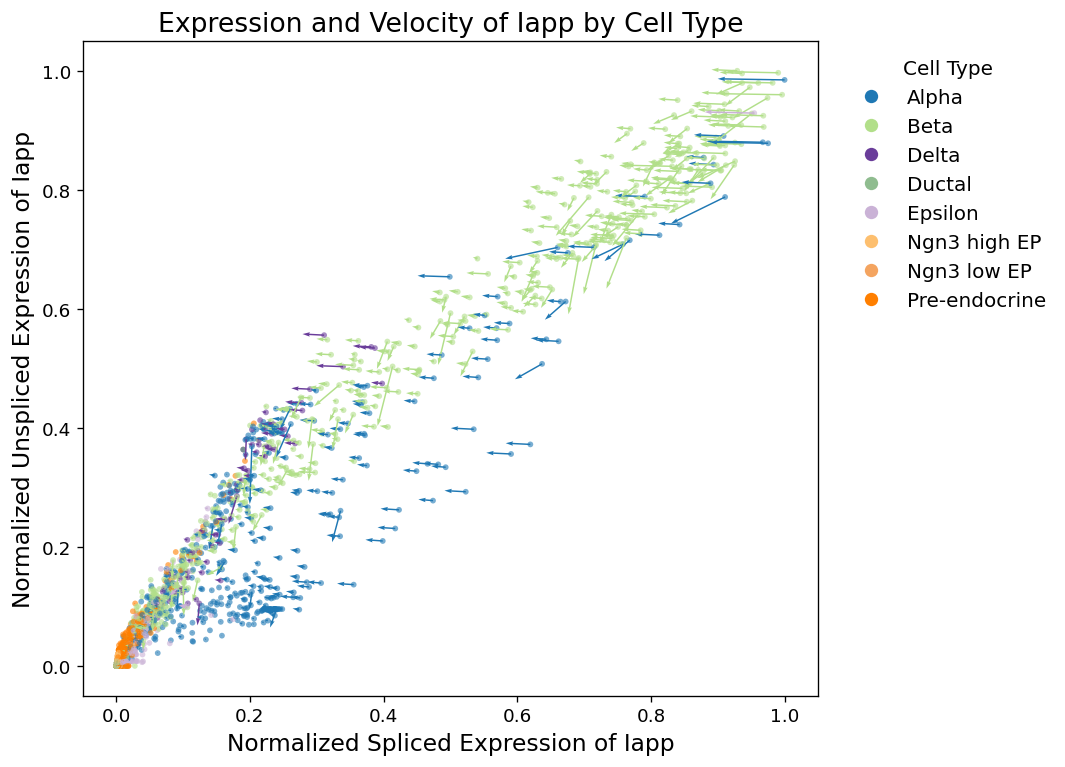

(<Figure size 1080x780 with 1 Axes>,
 <Axes: title={'center': 'Expression and Velocity of Iapp by Cell Type'}, xlabel='Normalized Spliced Expression of Iapp', ylabel='Normalized Unspliced Expression of Iapp'>)

In [10]:
lineagevi.plots.plot_phase_plane(adata, 'Iapp', u_scale=.1, s_scale=.1, alpha=1, head_width=0.02, head_length=0.03, length_includes_head=False)